### work with one boundary

In [2]:
import numpy as np 
import open3d as o3d
from scipy.ndimage import median_filter


input_path="/Users/seojiwoo/Desktop/"
output_path="/Users/seojiwoo/Desktop/"
dataname="upper_boundaries_0.npy"
retina_data = np.load('/Users/seojiwoo/Desktop/upper_boundaries_0.npy') 

retina_data = np.transpose(retina_data, (0,2,1))
retina_data_point_cloud = np.argwhere(retina_data == 1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(retina_data_point_cloud)
o3d.io.write_point_cloud("sync.ply", pcd)

pcd.estimate_normals()
pcd.has_normals()

In [5]:
#removing anomalies 

import open3d as o3d
import numpy as np


# Get the points as a NumPy array
points = np.asarray(pcd.points)

# Compute the mean and standard deviation of y-coordinates
y_mean = np.mean(points[:, 1])
y_std = np.std(points[:, 1])

# Set the threshold for anomaly detection
threshold = 4  # Example value: 2 standard deviations from the mean. 4 stdev seems to capture better though (at least for this case)

# Find the indices of the points within the threshold
valid_indices = np.where((points[:, 1] >= y_mean - threshold * y_std) & (points[:, 1] <= y_mean + threshold * y_std))[0]

# Create a new point cloud with only the valid points
new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(points[valid_indices])

# Optional: if your point cloud has normals, you can keep the corresponding normals as well
if pcd.has_normals():
    normals = np.asarray(pcd.normals)
    new_pcd.normals = o3d.utility.Vector3dVector(normals[valid_indices])

In [6]:
#run Poisson surface reconstruction
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        new_pcd, depth=9)
print(mesh)

run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 65532 / 58344
[Open3D DEBUG] #   Got kernel density: 0.0130389 (s), 288.387 (MB) / 288.387 (MB) / 288 (MB)
[Open3D DEBUG] #     Got normal field: 0.140971 (s), 308.82 (MB) / 308.82 (MB) / 308 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 8.961189e-06 / 5.872446e-01
[Open3D DEBUG] #       Finalized tree: 0.102279 (s), 337.07 (MB) / 337.07 (MB) / 337 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.163523 (s), 345.098 (MB) / 345.098 (MB) / 345 (MB)
[Open3D DEBUG] #Set point constraints: 0.0233829 (s), 346.414 (MB) / 346.414 (MB) / 346 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 636756 / 708752 / 18969
[Open3D DEBUG] Memory Usage: 346.414 MB
Cycle[0] Depth[0/9]:	[Open3D DEBUG] # Linear system solved: 0.507371 (s), 370.68 (MB) / 370.68 (MB) / 370 (MB)
Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(350.543 MB)	Nodes: 8
CG: 3.2940e-01 -> 3.2940e-01 -> 1.9980e-06 (6.1e-06) [0]

In [9]:
#chopping the mesh 

import open3d as o3d
import numpy as np


# Set the z-axis bounds
z_min = 0
z_max = 127

# Get the vertex coordinates as a NumPy array
vertices = np.asarray(mesh.vertices)

# Find the indices of the vertices within the z-axis bounds
valid_indices = np.where((vertices[:, 2] >= z_min) & (vertices[:, 2] <= z_max))[0]

# Create a new mesh with only the valid vertices and triangles
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(vertices[valid_indices])

# Find the triangles that have all their vertices within the bounds
valid_triangles = []

# Create a dictionary for mapping old indices to new indices
index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(valid_indices)}

for tri in np.asarray(mesh.triangles):
    if all(v in valid_indices for v in tri):
        # Update the triangle vertex indices to match the new mesh vertices
        new_tri = [index_map[v] for v in tri]
        valid_triangles.append(new_tri)

mesh.triangles = o3d.utility.Vector3iVector(valid_triangles)

# Compute vertex normals for the new mesh
mesh.compute_vertex_normals()

# # Visualize the new mesh
# o3d.visualization.draw_geometries([new_mesh])



TriangleMesh with 114148 points and 0 triangles.

In [13]:
#getting surface roughness matrix 

import numpy as np

# Assuming 'mesh' is your reconstructed mesh
vertices = np.asarray(mesh.vertices) #shape = (124599, 3)
triangles = np.asarray(mesh.triangles) #shape =  (248946, 3)

# Compute the centroid of the mesh
centroid = vertices.mean(axis=0)

# Compute the normal vector of the plane that best fits the points
u, s, vh = np.linalg.svd(vertices - centroid, full_matrices=False) #because it was computationally intensive. the reduced dimensions calculation works, but we do not know how accurate this is. 
normal = vh[2]

# Compute the distance from each vertex to the plane
distances = np.abs(np.dot(vertices - centroid, normal))

# Calculate the surface roughness as the root mean square of the distances
surface_roughness = np.sqrt(np.mean(distances ** 2))
print(surface_roughness)


8.539368926984409


In [18]:
import open3d as o3d
import trimesh
import numpy as np

# Load the mesh
trimesh_mesh = trimesh.load_mesh("/Users/seojiwoo/Desktop/mesh.obj")

# Compute the vertex defects (the discrete Gaussian curvature measure)
vertex_defects = trimesh.curvature.vertex_defects(trimesh_mesh)

# Compute the Gaussian curvature from vertex defects
gaussian_curvature = 2 * np.pi - vertex_defects

print(gaussian_curvature)
gaussian_curvature.shape


# Compute the average (mean) value of the Gaussian curvature
average = np.mean(gaussian_curvature)

# Compute the minimum value of the Gaussian curvature
minimum = np.min(gaussian_curvature)

# Compute the maximum value of the Gaussian curvature
maximum = np.max(gaussian_curvature)

# Compute the standard deviation of the Gaussian curvature
stdev = np.std(gaussian_curvature)

# Print the results
print(f"Average: {average:.2f}")
print(f"Minimum: {minimum:.2f}")
print(f"Maximum: {maximum:.2f}")
print(f"Standard deviation: {stdev:.2f}")

[1.5707616  3.14152097 3.14151605 ... 3.14186627 1.57055949 3.14192303]
Average: 6.28
Minimum: 0.16
Maximum: 12.30
Standard deviation: 0.31


Trying to scale it up 

In [8]:
import numpy as np
import open3d as o3d
import os
import pandas as pd
import trimesh
from scipy.ndimage import median_filter

def process_npy_file(input_file):
    retina_data = np.load(input_file)
    retina_data = np.transpose(retina_data, (0, 2, 1))
    retina_data_point_cloud = np.argwhere(retina_data == 1)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(retina_data_point_cloud)
    o3d.io.write_point_cloud("sync.ply", pcd)

    pcd.estimate_normals()
    pcd.has_normals()

    points = np.asarray(pcd.points)
    y_mean = np.mean(points[:, 1])
    y_std = np.std(points[:, 1])

    threshold = 4

    valid_indices = np.where((points[:, 1] >= y_mean - threshold * y_std) & (points[:, 1] <= y_mean + threshold * y_std))[0]

    new_pcd = o3d.geometry.PointCloud()
    new_pcd.points = o3d.utility.Vector3dVector(points[valid_indices])

    if pcd.has_normals():
        normals = np.asarray(pcd.normals)
        new_pcd.normals = o3d.utility.Vector3dVector(normals[valid_indices])

    with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
        mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(new_pcd, depth=9)

    z_min = 0
    z_max = 127

    vertices = np.asarray(mesh.vertices)
    valid_indices = np.where((vertices[:, 2] >= z_min) & (vertices[:, 2] <= z_max))[0]

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices[valid_indices])

    valid_triangles = []
    index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(valid_indices)}

    for tri in np.asarray(mesh.triangles):
        if all(v in valid_indices for v in tri):
            new_tri = [index_map[v] for v in tri]
            valid_triangles.append(new_tri)

    mesh.triangles = o3d.utility.Vector3iVector(valid_triangles)
    mesh.compute_vertex_normals()

    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    centroid = vertices.mean(axis=0)
    u, s, vh = np.linalg.svd(vertices - centroid, full_matrices=False)
    normal = vh[2]
    distances = np.abs(np.dot(vertices - centroid, normal))
    surface_roughness = np.sqrt(np.mean(distances ** 2))

    trimesh_mesh = trimesh.Trimesh(vertices=vertices, faces=triangles)
    vertex_defects = trimesh.curvature.vertex_defects(trimesh_mesh)
    gaussian_curvature = 2 * np.pi - vertex_defects

    average = np.mean(gaussian_curvature)
    minimum = np.min(gaussian_curvature)
    maximum = np.max(gaussian_curvature)
    stdev = np.std(gaussian_curvature)

    return surface_roughness, average, minimum, maximum, stdev


In [9]:
input_folder = "/Users/seojiwoo/Desktop/Downloads"
output_file = "/Users/seojiwoo/Desktop/results.csv"

results = []

for file in os.listdir(input_folder):
    if file.endswith(".npy"):
        input_path = os.path.join(input_folder, file)
        try:
            surface_roughness, average, minimum, maximum, stdev = process_npy_file(input_path)
            results.append({
                'filename': file,
                'surface_roughness': surface_roughness,
                'gaussian_curvature_average': average,
                'gaussian_curvature_minimum': minimum,
                'gaussian_curvature_maximum': maximum,
                'gaussian_curvature_stdev': stdev
            })
            print(f"Processed {file}")
        except Exception as e:
            print(f"Error processing {file}: {e}")

results_df = pd.DataFrame(results)
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")



[Open3D DEBUG] Input Points / Samples: 65536 / 59097
[Open3D DEBUG] #   Got kernel density: 0.036315 (s), 872.02 (MB) / 872.02 (MB) / 880 (MB)
[Open3D DEBUG] #     Got normal field: 0.378213 (s), 879.805 (MB) / 879.805 (MB) / 880 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 8.121500e-06 / 5.322506e-01
[Open3D DEBUG] #       Finalized tree: 0.199974 (s), 895.996 (MB) / 895.996 (MB) / 895 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.543958 (s), 898.309 (MB) / 898.309 (MB) / 898 (MB)
[Open3D DEBUG] #Set point constraints: 0.0562751 (s), 898.312 (MB) / 898.312 (MB) / 898 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 643308 / 722512 / 12697
[Open3D DEBUG] Memory Usage: 898.312 MB
Cycle[0] Depth[0/9]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(898.316 MB)	Nodes: 8
CG: 2.7564e-01 -> 2.7564e-01 -> 4.4859e-05 (1.6e-04) [0]
[Open3D DEBUG] # Linear system solved: 1.00558 (s), 905.66 (MB) / 905.66 (MB) / 905 (MB)
Cycle[0] Depth[1/9]:	Updated const

In [22]:
!pip install pymesh
import numpy as np
import open3d as o3d
import os
import glob
import pymesh

input_path = "/Users/seojiwoo/Desktop/Downloads"
output_path = "/Users/seojiwoo/Desktop/Downloads"

def process_file(file_path):
    retina_data = np.load(file_path)
    retina_data = np.transpose(retina_data, (0, 2, 1))
    retina_data_point_cloud = np.argwhere(retina_data == 1)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(retina_data_point_cloud)
    pcd.estimate_normals()

    # Using ball pivoting algorithm
    radii = [0.005, 0.01, 0.02, 0.04]
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector(radii))
    mesh.compute_vertex_normals()

    # Convert Open3D mesh to PyMesh mesh
    pymesh_mesh = pymesh.form_mesh(np.asarray(mesh.vertices), np.asarray(mesh.triangles))

    # Compute Gaussian curvature
    curvatures = pymesh.curvature(pymesh_mesh)
    avg_curvature = np.mean(curvatures)
    min_curvature = np.min(curvatures)
    max_curvature = np.max(curvatures)

    return avg_curvature, min_curvature, max_curvature

for file in glob.glob(os.path.join(input_path, "*.npy")):
    avg_curvature, min_curvature, max_curvature = process_file(file)
    print(f"File: {os.path.basename(file)}")
    print(f"Average Gaussian Curvature: {avg_curvature}")
    print(f"Minimum Gaussian Curvature: {min_curvature}")
    print(f"Maximum Gaussian Curvature: {max_curvature}")
    print("\n")


  Using cached pymesh-1.0.2-py3-none-any.whl


AttributeError: module 'pymesh' has no attribute 'form_mesh'

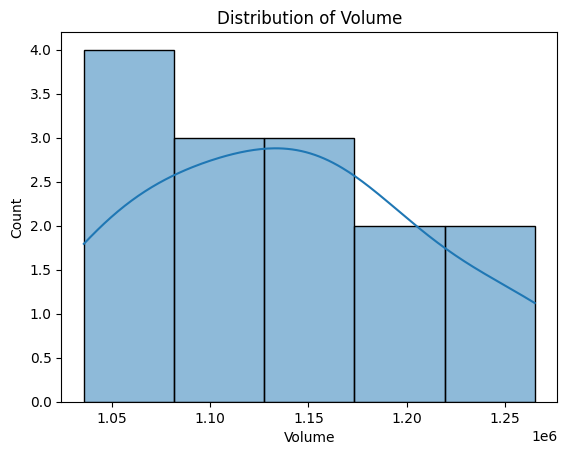

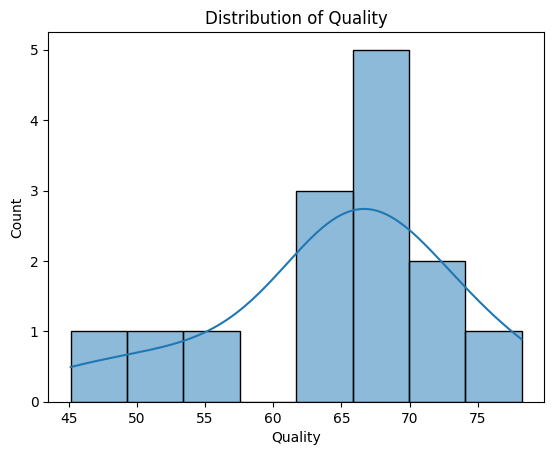

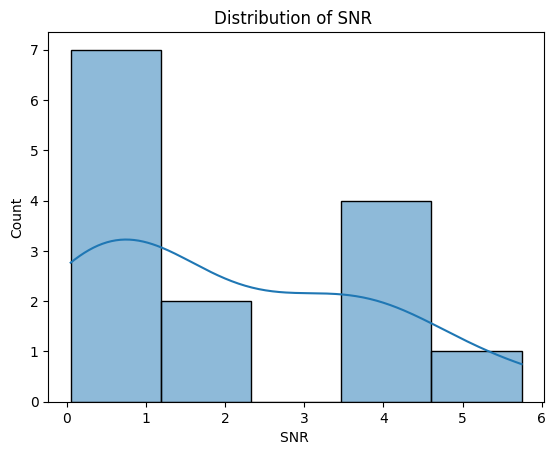

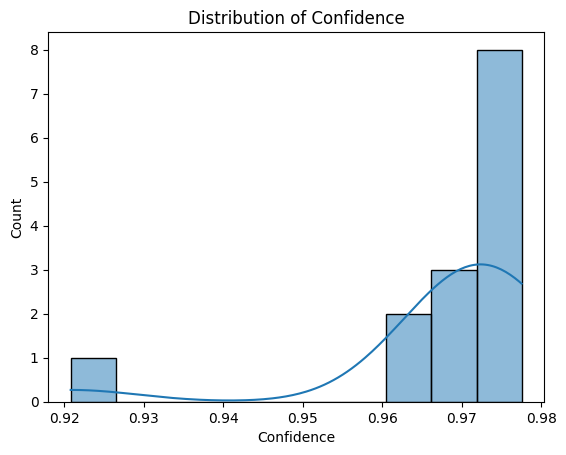

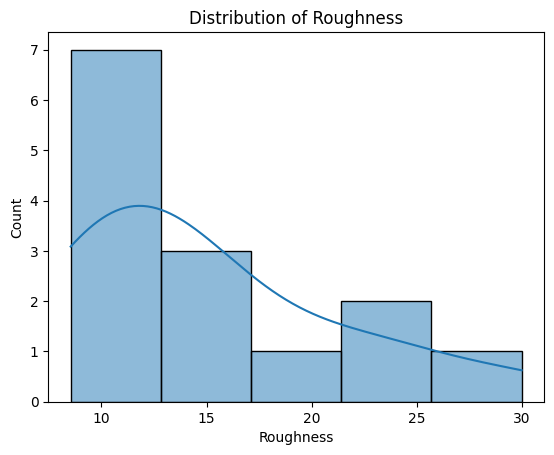

Feature importances:
Volume        0.094240
SNR           0.278577
Confidence    0.497753
Roughness     0.129430
dtype: float64

Correlation matrix:
              Volume      SNR   Confidence  Roughness
Volume      1.000000  0.096601    0.024146  -0.560616
SNR         0.096601  1.000000   -0.431723  -0.058970
Confidence  0.024146 -0.431723    1.000000  -0.272253
Roughness  -0.560616 -0.058970   -0.272253   1.000000


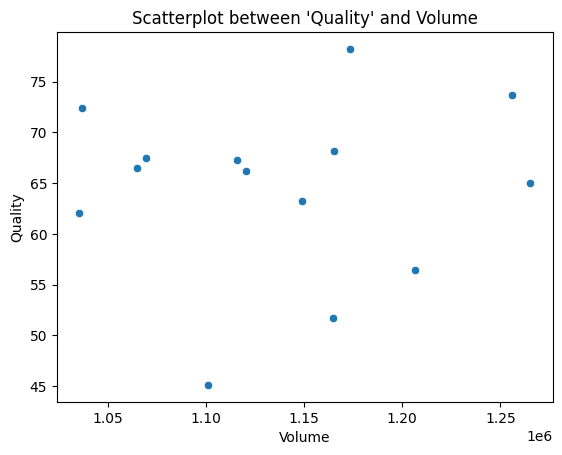

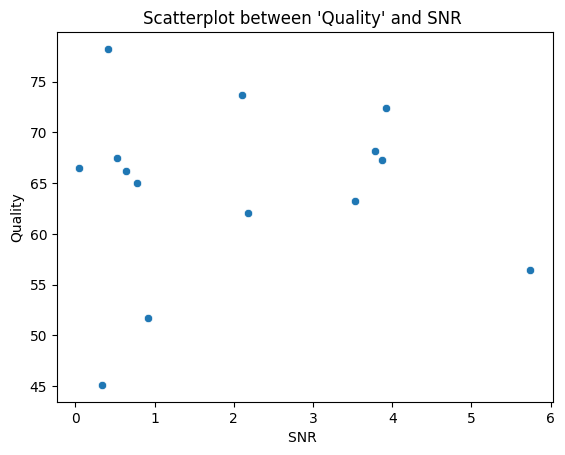

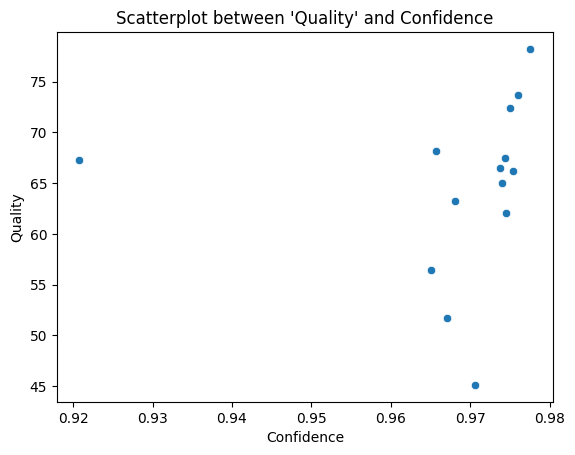

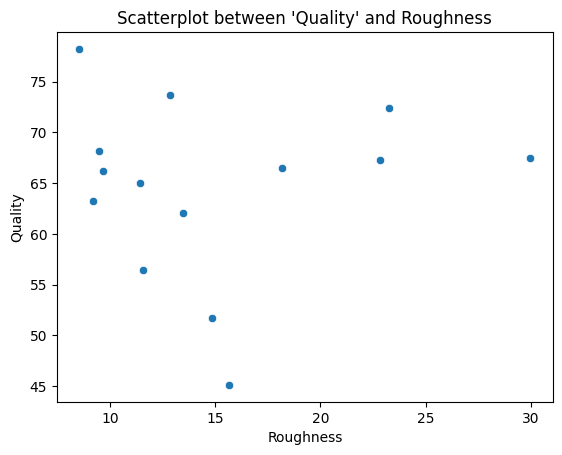

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Replace this line with the actual code to read or create your DataFrame
df = pd.read_excel("/Users/seojiwoo/Desktop/Book1.xlsx") 

# Convert non-numeric values to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Option 1: Drop rows containing NaN values
df = df.dropna() 

# Distribution of each of the columns
for col in df.columns:
    plt.figure()
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Feature importance for 'quality' by other columns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Quality"])
y = df["Quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
print("Feature importances:")
print(feature_importances)

# Correlation between columns other than 'Quality'
correlation_matrix = df.drop(columns=["Quality"]).corr()
print("\nCorrelation matrix:")
print(correlation_matrix)

# Scatterplot between 'Quality' value and other columns
for col in X.columns:
    plt.figure()
    sns.scatterplot(data=df, x=col, y="Quality")
    plt.title(f"Scatterplot between 'Quality' and {col}")
    plt.show()


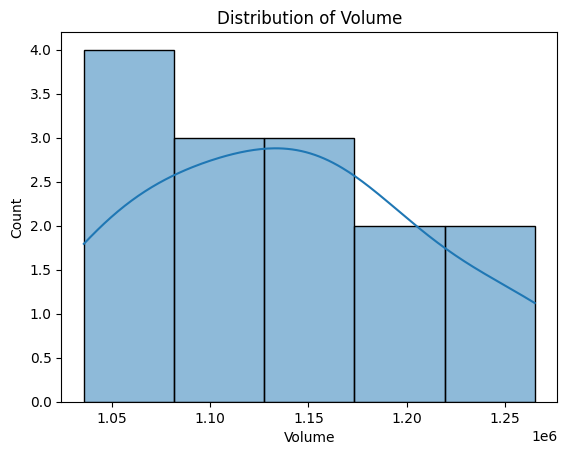

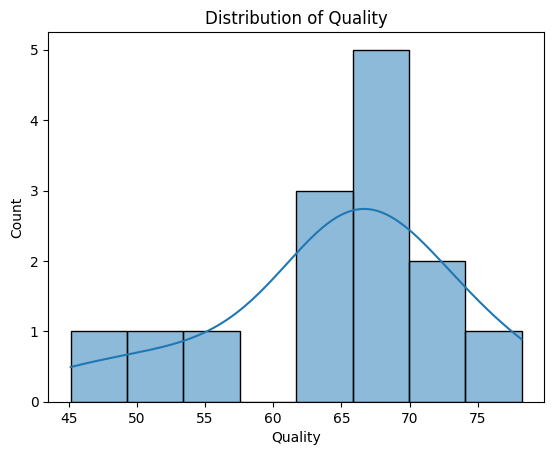

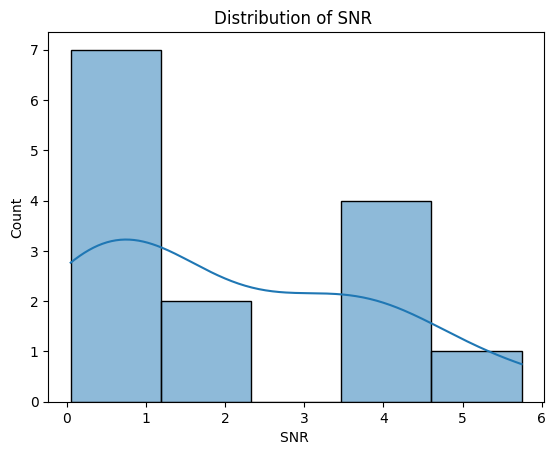

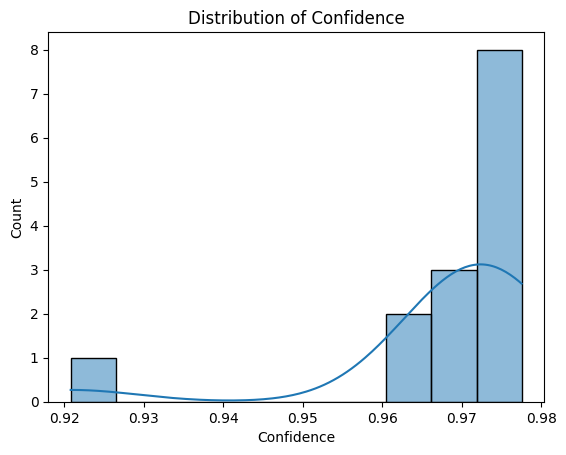

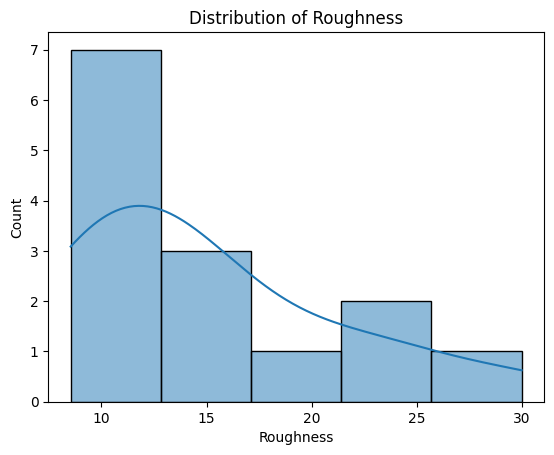

Feature importances:
SNR           0.310455
Confidence    0.514639
Roughness     0.174906
dtype: float64

Correlation matrix:
              Volume      SNR   Confidence  Roughness
Volume      1.000000  0.096601    0.024146  -0.560616
SNR         0.096601  1.000000   -0.431723  -0.058970
Confidence  0.024146 -0.431723    1.000000  -0.272253
Roughness  -0.560616 -0.058970   -0.272253   1.000000


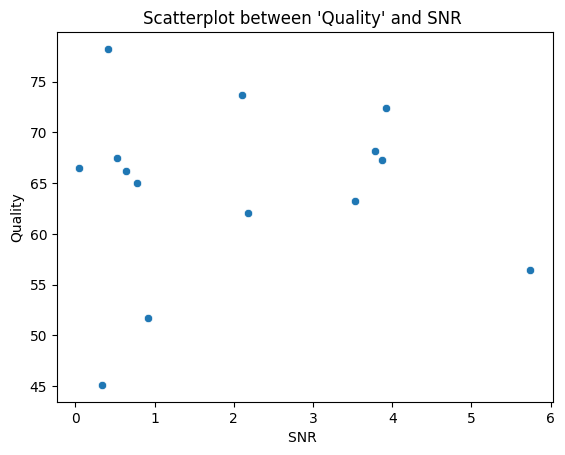

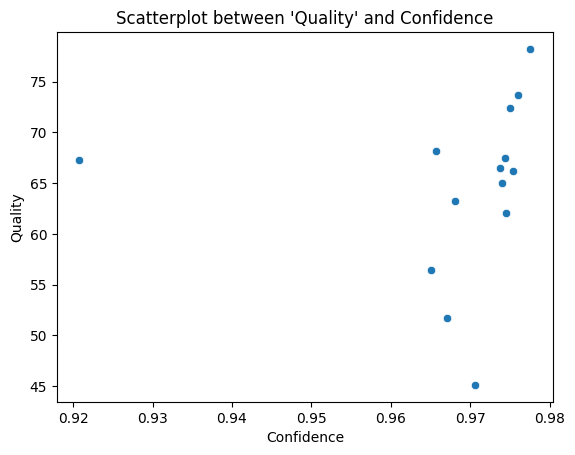

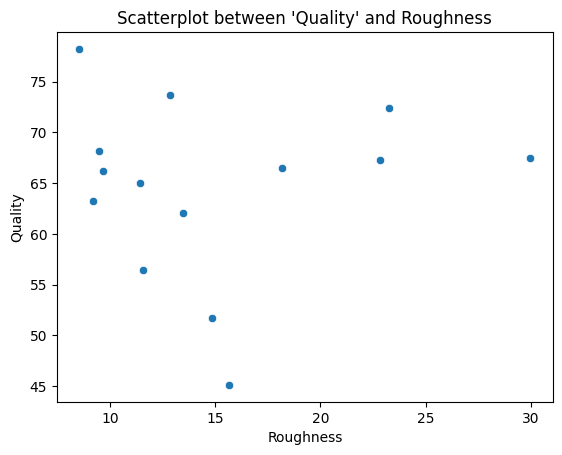


Random Forest performance:
R-squared score: -10.3799
Mean Squared Error: 46.6708
Mean Absolute Error: 6.2452


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming your DataFrame is named df
# Replace this line with the actual code to read or create your DataFrame
# df = pd.read_csv("your_data.csv") or pd.DataFrame(data)

# # Convert non-numeric values to NaN
# df = df.apply(pd.to_numeric, errors='coerce')

# Option 1: Drop rows containing NaN values
df = df.dropna()

# Option 2: Fill NaN values with the mean of the respective column
# df = df.fillna(df.mean())

# Distribution of each of the columns
for col in df.columns:
    plt.figure()
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Feature importance for 'quality' by other columns
X = df.drop(columns=["Quality", "Volume"])
y = df["Quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
print("Feature importances:")
print(feature_importances)

# Correlation between columns other than 'Quality'
correlation_matrix = df.drop(columns=["Quality"]).corr()
print("\nCorrelation matrix:")
print(correlation_matrix)

# Scatterplot between 'Quality' value and other columns
for col in X.columns:
    plt.figure()
    sns.scatterplot(data=df, x=col, y="Quality")
    plt.title(f"Scatterplot between 'Quality' and {col}")
    plt.show()

# Performance result of the Random Forest model
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nRandom Forest performance:")
print(f"R-squared score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


In [27]:
!pip install lazypredict


In [37]:
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

df = pd.read_excel("/Users/seojiwoo/Desktop/Book1.xlsx") 

print(df)

X = df.drop(columns=["Quality", "Volume"], axis = 1 )
y = df["Quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

     Volume  Quality  SNR  Confidence  Roughness
0   1035666    62.08  2.18       0.97      13.44
1   1036909    72.36  3.93       0.98      23.24
2   1101194    45.13  0.34       0.97      15.66
3   1115750    67.26  3.88       0.92      22.85
4   1164524    51.75  0.91       0.97      14.85
5   1165002    68.21  3.78       0.97       9.45
6   1173522    78.22  0.41       0.98       8.54
7   1255698    73.69  2.11       0.98      12.82
8   1265212    64.99  0.77       0.97      11.40
9   1064836    66.51  0.05       0.97      18.16
10  1069517    67.50  0.52       0.97      29.98
11  1120239    66.21  0.64       0.98       9.64
12  1131419    56.86  1.40                 11.70
13  1148936    63.22  3.52       0.97       9.16
14  1162243    57.23  0.84                 16.69
15  1206621    56.45  5.74       0.96      11.55


100%|██████████| 29/29 [00:00<00:00, 166.03it/s]

Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []


In [47]:
df = pd.read_excel("/Users/seojiwoo/Desktop/Book1.xlsx") 

df = df.dropna(thresh=df.shape[1])

print(df.dtypes)

df['Volume'] = df['Volume'].astype('float64')
df["Confidence"] = df["Confidence"].astype('float64')


Volume          int64
Quality       float64
SNR           float64
Confidence    float64
Roughness     float64
dtype: object


In [48]:
import pandas as pd
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Read your dataset
df = pd.read_excel("/Users/seojiwoo/Desktop/Book1.xlsx")

df = df.dropna(thresh=df.shape[1])

# Prepare the feature matrix and target variable
X = df.drop(columns=["Quality", "Volume"], axis = 1)
y = df["Quality"]

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

# Instantiate the LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

# Fit the models and make predictions
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the performance of all models
print(models)


100%|██████████| 42/42 [00:01<00:00, 31.35it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                             100841.92 -201680.85 67.32        0.01
MLPRegressor                             70496.81 -140990.61 56.29        0.06
LinearSVR                                65767.15 -131531.30 54.36        0.01
GaussianProcessRegressor                 10141.31  -20279.61 21.35        0.01
RANSACRegressor                           9004.95  -18006.90 20.12        0.04
DecisionTreeRegressor                     6693.08  -13383.15 17.34        0.01
XGBRegressor                              4058.59   -8114.18 13.50        0.20
AdaBoostRegressor                         2846.38   -5689.76 11.31        0.12
BaggingRegressor                          2400.90   -4798.80 10.39        0.04
RandomForestRegressor                     2339.40   -4675.80 10.25        0.12
ExtraTreeRegressor                        1616.40   